In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import matplotlib.pyplot as plt

from torchtext.legacy.data import Field, BucketIterator, TabularDataset

import spacy
import numpy as np
import pandas as pd

import random
import math
import time
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [2]:
SEED = 1234

random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

Sentence polarity dataset: Yelp, amazon, IMDB

Loading IMDB data

In [4]:
Data = pd.read_csv("/content/IMDB Dataset.csv")
Data.columns

Index(['review', 'sentiment'], dtype='object')

In [5]:
Positive = Data[Data['sentiment']=='positive']
Negative = Data[Data['sentiment']=='negative']
len(Positive), len(Negative)

(25000, 25000)

In [6]:
Positive.head()

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive
5,"Probably my all-time favorite movie, a story o...",positive


In [7]:
Positive['review'] = Positive['review'].apply(lambda x: ' . '.join(x.lower().split('<br /><br />'))).apply(lambda x: ' '.join(x.split()[:25]))
Negative['review'] = Negative['review'].apply(lambda x: ' . '.join(x.lower().split('<br /><br />'))).apply(lambda x: ' '.join(x.split()[:25]))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [8]:
Positive.head()

,review,sentiment
0,one of the other reviewers has mentioned that ...,positive
1,a wonderful little production. . the filming t...,positive
2,i thought this was a wonderful way to spend ti...,positive
4,"petter mattei's ""love in the time of money"" is...",positive
5,"probably my all-time favorite movie, a story o...",positive


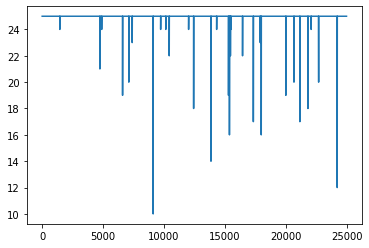

In [9]:
plt.plot([len(x.split()) for x in Positive['review']])

In [10]:
Positive_train = Positive['review'][:24000]
Positive_test = Positive['review'][-1000:]

Negative_train = Negative['review'][:24000]
Negative_test = Negative['review'][-1000:]
len(Positive_train),len(Positive_test),len(Negative_train),len(Negative_test)

(24000, 1000, 24000, 1000)

In [90]:
Negative.tail()

,review,sentiment
49994,this is your typical junk comedy. . there are ...,negative
49996,"bad plot, bad dialogue, bad acting, idiotic di...",negative
49997,i am a catholic taught in parochial elementary...,negative
49998,i'm going to have to disagree with the previou...,negative
49999,no one expects the star trek movies to be high...,negative


In [11]:
Positive_train.to_csv('/content/Positive_train.csv',index=False)
Positive_test.to_csv('/content/Positive_test.csv',index=False)

Negative_train.to_csv('/content/Negative_train.csv',index=False)
Negative_test.to_csv('/content/Negative_test.csv',index=False)

In [ ]:
# Positive = Data[Data['sentiment'] == 1]
# Negative = Data[Data['sentiment'] == 0]
# Negative.head()

Loading of Amazon Data

In [ ]:
# Positive = pd.read_csv("/content/amazon_pos_data.csv")
# Negative = pd.read_csv("/content/amazon_neg_data.csv")

In [ ]:
# len(Positive), len(Negative)

In [ ]:
# Positive_train = Positive[:5000]
# Positive_test = Positive.iloc[-1000:,:]

# Negative_train = Negative[:5000]
# Negative_test = Negative.iloc[-1000:,:]
# len(Positive_train),len(Positive_test),len(Negative_train),len(Negative_test)

In [ ]:
# Positive_train.to_csv('/content/Positive_train.csv',index=False)
# Positive_test.to_csv('/content/Positive_test.csv',index=False)

# Negative_train.to_csv('/content/Negative_train.csv',index=False)
# Negative_test.to_csv('/content/Negative_test.csv',index=False)

In [ ]:
# Positive_train.head()

In [12]:
spacy_en = spacy.load('en_core_web_sm')

def tokenizer(text):
  # return text.split()
  return [tok.text for tok in spacy_en.tokenizer(text)]

Positive sentiment data generation

In [13]:
POS_REVIEW = Field(sequential=True,
                  tokenize = tokenizer,
                  use_vocab = True, 
                  init_token = '<sos>', 
                  eos_token = '<eos>', 
                  lower = True)

# ORIGINAL = Field(sequential=True,
#                 tokenize = tokenizer, 
#                 use_vocab = True,                 
#                 init_token = '<sos>', 
#                 eos_token = '<eos>', 
#                 lower = True)

fields = [('review', POS_REVIEW)] # ('token_type', TTYPE), ('start',START), ('end',END)]

In [14]:
pos_train_data, pos_test_data = TabularDataset.splits(
                                        path = '/content/',
                                        train = 'Positive_train.csv',
                                        test = 'Positive_test.csv',
                                        format = 'csv',
                                        fields = fields,
                                        skip_header = True)
print(type(pos_train_data))

<class 'torchtext.legacy.data.dataset.TabularDataset'>


In [3]:
from torchtext.vocab import FastText
import os
# embedding_glove = GloVe(name='6B', dim=100)

cache = '/content/.vector_cache'
if not os.path.exists(cache):
    os.mkdir(cache)
vectors = FastText(language='en', cache=cache)

/content/.vector_cache/wiki.en.vec: 6.60GB [02:38, 41.5MB/s]                            
100%|██████████| 2519370/2519370 [05:58<00:00, 7028.44it/s]


In [15]:
POS_REVIEW.build_vocab(pos_train_data,pos_test_data, vectors = vectors) # train_data must be of type <class 'torchtext.legacy.data.dataset.TabularDataset'>
# ORIGINAL.build_vocab(train_data,test_data)  # train_data must be of type <class 'torchtext.legacy.data.dataset.TabularDataset'

In [16]:
print(len(POS_REVIEW.vocab))
print(POS_REVIEW.vocab.stoi['<eos>'] , POS_REVIEW.vocab.stoi['<sos>'])
print(pos_train_data[0].__dict__.keys())
print(pos_train_data[20].__dict__.values())

28537
3 2
dict_keys(['review'])
dict_values([['this', 'movie', 'struck', 'home', 'for', 'me', '.', 'being', '29', ',', 'i', 'remember', 'the', "'", '80', "'s", 'and', 'my', 'father', 'working', 'in', 'a', 'factory', '.', 'i', 'figured', ',', 'if', 'i', 'worked', 'hard']])


In [17]:
BATCH_SIZE = 128

pos_train_iterator, pos_test_iterator = BucketIterator.splits(
                                                      (pos_train_data, pos_test_data), 
                                                      batch_size = BATCH_SIZE,
                                                      sort_key = lambda x : len(x.review),
                                                      shuffle = False,
                                                      device = device
                                                    )

In [18]:
device

device(type='cuda')

**nn.Module.register_parameter** takes the tensor or None but first checks if the name is in dictionary of the module. While **nn.Parameter** doesn’t have such check.

In [19]:
class Highway(nn.Module):
    def __init__(self, size, num_layers, f):

        super(Highway, self).__init__()

        self.num_layers = num_layers

        self.nonlinear = [nn.Linear(size, size) for _ in range(num_layers)]
        for i, module in enumerate(self.nonlinear):
            self._add_to_parameters(module.parameters(), 'nonlinear_module_{}'.format(i))

        self.linear = [nn.Linear(size, size) for _ in range(num_layers)]
        for i, module in enumerate(self.linear):
            self._add_to_parameters(module.parameters(), 'linear_module_{}'.format(i))

        self.gate = [nn.Linear(size, size) for _ in range(num_layers)]
        for i, module in enumerate(self.gate):
            self._add_to_parameters(module.parameters(), 'gate_module_{}'.format(i))

        self.f = f

    def forward(self, x):
        """
        :param x: tensor with shape of [batch_size, emb_dim]
        :return: tensor with shape of [batch_size, emb_dim]
        applies σ(x) ⨀ (f(G(x))) + (1 - σ(x)) ⨀ (Q(x)) transformation | G and Q is affine transformation,
            f is non-linear transformation, σ(x) is affine transformation with sigmoid non-linearition
            and ⨀ is element-wise multiplication
        """

        for layer in range(self.num_layers):
            gate = F.sigmoid(self.gate[layer](x))

            nonlinear = self.f(self.nonlinear[layer](x))
            linear = self.linear[layer](x)

            x = gate * nonlinear + (1 - gate) * linear

        return x

    def _add_to_parameters(self, parameters, name):
        for i, parameter in enumerate(parameters):
            self.register_parameter(name='{}-{}'.format(name, i), param=parameter)


# hw = Highway(10,5,F.relu)

# for i,name in enumerate(hw.named_parameters()):
#   print(name)

In [20]:
class Encoder(nn.Module):
    def __init__(self, input_dim, emb_dim, enc_hid_dim, dec_hid_dim, dropout, latent_dim, device):
        super(Encoder, self).__init__()
        
        self.embedding = nn.Embedding(input_dim, emb_dim)
        
        self.hw1 = Highway(emb_dim, 2, F.relu)

        self.rnn = nn.GRU(emb_dim, enc_hid_dim, num_layers = 2, bidirectional = True, dropout = 0.25)
        
        self.w_mu = nn.Linear(enc_hid_dim*2, latent_dim, device=device)
        self.w_sigma = nn.Linear(enc_hid_dim*2, latent_dim, device=device)

        self.hw2 = Highway(enc_hid_dim * 2, 3, F.relu)

        self.N = torch.distributions.Normal(0, 1)

        # if device == 'cuda':
        self.N.loc = self.N.loc.to(device)
        self.N.scale = self.N.scale.to(device)

        self.dropout = nn.Dropout(dropout)
        self.device = device
        # self.fc = nn.Linear(2*enc_hid_dim, dec_hid_dim)
        
    def forward(self, src):
        
        #src = [src len, batch size]
        
        embedded = self.dropout(self.embedding(src))  #embedded = [src len, batch size, emb dim]
        src_len, batch_sz, emb_dim = embedded.shape[0], embedded.shape[1], embedded.shape[2]

        embedded = embedded.view(-1, emb_dim)
        embedded = self.hw1(embedded) # [ -1, emb_dim]

        embedded = embedded.view(src_len, batch_sz, emb_dim)  #embedded = [src len, batch size, emb dim]
        
        outputs, hidden = self.rnn(embedded)

        #outputs = [src len, batch size, enc hid dim * num directions]
        #hidden = [n layers * num directions, batch size, hid dim]
        h = torch.cat(((hidden[-1,:,:]+hidden[-2,:,:])/2, (hidden[-3,:,:]+hidden[-4,:,:])/2), dim = -1)

        #h = [batch size, encoder hidden dim * 2]

        h = self.hw2(h)

        mu, sigma = self.w_mu(h), self.w_sigma(h)
        
        #outputs = [src len, batch size, enc hid dim*2]

        #mu , sigma = [batch sz, latent dim], [batch size, latent dim]
        z = mu + torch.exp(0.5*sigma) * self.N.sample(mu.shape)
        
        return h, mu, sigma, z

In [21]:
class Decoder(nn.Module):
    def __init__(self, output_dim, emb_dim, enc_hid_dim, dec_hid_dim, dropout, encoder):
        super(Decoder, self).__init__()

        self.output_dim = output_dim
        
        # self.embedding = nn.Embedding(output_dim,emb_dim)
        self.embedding = encoder.embedding
        
        self.rnn = nn.GRU(emb_dim, dec_hid_dim, dropout = 0.30)
        
        self.fc_out = nn.Linear( dec_hid_dim , output_dim)
        
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, input, hidden):
             
        #input = [batch size]
        #hidden = [batch size, dec hid dim]
        #encoder_outputs = [src len, batch size, enc hid dim * 2]
        
        input = input.unsqueeze(0)
        
        #input = [1, batch size]
        
        embedded = self.dropout(self.embedding(input.long()))
        
        #embedded = [1, batch size, emb dim]
            
        output, hidden = self.rnn(embedded, hidden.unsqueeze(0))
        
        #output = [seq len, batch size, dec hid dim * n directions]
        #hidden = [n layers * n directions, batch size, dec hid dim]
        
        #output = [1, batch size, dec hid dim]
        #hidden = [1, batch size, dec hid dim]
        assert (output == hidden).all()
        
        output = output.squeeze(0)
        
        prediction = self.fc_out(output)
        
        #prediction = [batch size, output dim]
        
        return prediction, hidden.squeeze(0)

In [22]:
class Seq2Seq(nn.Module):
    def __init__(self, encoder, decoder, device, latent_dim, dec_hid_dim):
        super(Seq2Seq, self).__init__()
        
        self.encoder = encoder
        self.decoder = decoder
        self.device = device
        self.latent_dim = latent_dim
        self.teacher_forcing_ratio = 0.50
        
    def forward(self, src, trg, sentiment = "pos"):
        
        #src = [src len, batch size]
        #trg = [trg len, batch size]
        
        batch_size = src.shape[1]
        trg_len = trg.shape[0]
        trg_vocab_size = self.decoder.output_dim
        
        #tensor to store decoder outputs
        outputs = torch.zeros(trg_len, batch_size, trg_vocab_size).to(self.device)
        
        _, mu, sigma, z  = self.encoder(src) # , mu, sigma, z

        # -1 for neg and 1 for pos
        scale = 1
        if sentiment == "neg":
          scale = -1

        self.kl = -0.5*(-(mu-scale)**2 - torch.exp(sigma) + 1 + sigma).sum()/batch_size        # avg kl loss across batch

        input = trg[0,:]
        
        hidden = z
        
        for t in range(1, trg_len):
            
            output, hidden = self.decoder(input, hidden)
            
            outputs[t] = output
            teacher_force = random.random() < self.teacher_forcing_ratio
            top1 = output.argmax(1)
            input = trg[t] if teacher_force else torch.zeros(top1.shape).to(device) # force <unk> token 50% of the times

        return outputs

In [23]:
ENC_EMB_DIM = 300
DEC_EMB_DIM = 300
ENC_HID_DIM = 50
DEC_HID_DIM = 50
LATENT_DIM = 50
ENC_DROPOUT = 0.3
DEC_DROPOUT = 0.3

In [24]:
def initialize_model(REVIEW,device):
  INPUT_DIM = len(REVIEW.vocab)
  OUTPUT_DIM = len(REVIEW.vocab)
  global ENC_EMB_DIM
  global DEC_EMB_DIM
  global ENC_HID_DIM
  global DEC_HID_DIM
  global LATENT_DIM
  global ENC_DROPOUT
  global DEC_DROPOUT

  # attn = Attention(ENC_HID_DIM, DEC_HID_DIM).to(device)
  enc = Encoder(INPUT_DIM, ENC_EMB_DIM, ENC_HID_DIM, DEC_HID_DIM, ENC_DROPOUT, LATENT_DIM, device).to(device)
  enc.embedding.weight.data.copy_(REVIEW.vocab.vectors)
  
  dec = Decoder(OUTPUT_DIM, DEC_EMB_DIM, ENC_HID_DIM, DEC_HID_DIM, DEC_DROPOUT, enc).to(device)

  model = Seq2Seq(enc, dec, device, LATENT_DIM, DEC_HID_DIM).to(device)

  return model, enc, dec

In [25]:
pos_model, pos_enc, pos_dec = initialize_model(POS_REVIEW,device)

/usr/local/lib/python3.7/dist-packages/torch/nn/modules/rnn.py:65: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  "num_layers={}".format(dropout, num_layers))


In [ ]:
# def init_weights(m):
#     for name, param in m.named_parameters():
#         if 'weight' in name:
#             nn.init.normal_(param.data, mean=0, std=0.05)
#         else:
#             nn.init.constant_(param.data, 0)  #  initialise bias with 0
            
# pos_model.apply(init_weights)

In [27]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f'The model has {count_parameters(pos_model),} trainable parameters')

The model has (10863287,) trainable parameters


In [28]:
optimizer = optim.Adam(pos_model.parameters(), lr = 0.005)

TRG_PAD_IDX = POS_REVIEW.vocab.stoi[POS_REVIEW.pad_token]

criterion = nn.CrossEntropyLoss(ignore_index = TRG_PAD_IDX).to(device)

In [29]:
def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

In [30]:
def frange_cycle_linear(n_iter, start=0.0, stop=1.0,  n_cycle=1, ratio=0.5):
    L = np.ones(n_iter) * stop
    period = n_iter/n_cycle
    step = (stop-start)/(period*ratio) # linear schedule

    for c in range(n_cycle):
        v, i = start, 0
        while v <= stop and (int(i+c*period) < n_iter):
            L[int(i+c*period)] = v
            v += step
            i += 1
    return L

In [31]:
def train(model, iterator, optimizer, criterion, clip, sentiment):
    
    global device

    model.train()
    
    epoch_loss = 0
    kl = 0
    
    for idx,batch in enumerate(iterator):
        
        src = batch.review.to(device)
        trg = batch.review.to(device)

        # print(src.shape,trg.shape)
        
        optimizer.zero_grad()
        
        output = model(src, trg, sentiment)
        
        #trg = [trg len, batch size]
        #output = [trg len, batch size, output dim]
        
        output_dim = output.shape[-1]
        
        output = output[1:].view(-1, output_dim)
        trg = trg[1:].view(-1)
        
        #trg = [(trg len - 1) * batch size]
        #output = [(trg len - 1) * batch size, output dim]
        
        loss = criterion(output, trg) + 100*model.kl
        
        loss.backward()
        
        torch.nn.utils.clip_grad_norm_(model.parameters(), clip)
        
        optimizer.step()
        
        epoch_loss += loss.item()
        kl += model.kl.item()
        
    # print(f"Shape of latent dict : {model.latent_dict.shape}")
    return epoch_loss / len(iterator), kl/len(iterator)

In [32]:
def test(model, iterator, sentiment):
    
    global device

    model.eval()
    
    epoch_loss = 0
    
    with torch.no_grad():
    
      for batch in iterator:
          
        src = batch.review.to(device)
        trg = batch.review.to(device)
              
        output = model(src, trg, sentiment)
        
        #trg = [trg len, batch size]
        #output = [trg len, batch size, output dim]
        
        output_dim = output.shape[-1]
        
        output_tokens = torch.argmax(output[1:], dim=-1).view(-1)
        output = output[1:].view(-1, output_dim)
        trg = trg[1:].view(-1)
        
        #trg = [(trg len - 1) * batch size]
        #output = [(trg len - 1) * batch size, output dim]
        
        loss = criterion(output, trg) + model.kl
        
        epoch_loss += loss.item()
        
    return epoch_loss / len(iterator), (output_tokens == trg).sum()

In [33]:
N_EPOCHS = 20
CLIP = 1

best_train_loss = float('inf')
ptl = []
pvl = []
pkl = []
sentiment = "pos"
#cyclic annealing 
# beta = frange_cycle_linear(N_EPOCHS*len(pos_train_iterator)) 
# plt.plot(beta)

for epoch in range(N_EPOCHS):
    
    start_time = time.time()
    
    train_loss, train_kl = train(pos_model, pos_train_iterator, optimizer, criterion, CLIP, sentiment)
    # valid_loss = evaluate(model, test_iterator, criterion)
    
    end_time = time.time()
    
    epoch_mins, epoch_secs = epoch_time(start_time, end_time)

    val_loss, validation_EM_score = test(pos_model, pos_test_iterator, sentiment)
    
    if val_loss < best_train_loss:
        best_train_loss = val_loss
        torch.save(pos_model.state_dict(), 'var_pos_seq2seq_2_imdb.pt')
    
    print(f'Epoch: {epoch+1:02} | Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.4f} | Validation_loss : {val_loss:.4f} | Validation EM score : {validation_EM_score}')
    ptl.append(train_loss)
    pvl.append(val_loss)
    pkl.append(train_kl)

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1806: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Epoch: 01 | Time: 2m 41s
	Train Loss: 120.1554 | Validation_loss : 6.5704 | Validation EM score : 225
Epoch: 02 | Time: 2m 40s
	Train Loss: 9.2862 | Validation_loss : 6.2035 | Validation EM score : 304
Epoch: 03 | Time: 2m 40s
	Train Loss: 7.6758 | Validation_loss : 5.9479 | Validation EM score : 383
Epoch: 04 | Time: 2m 40s
	Train Loss: 6.9222 | Validation_loss : 5.8796 | Validation EM score : 435
Epoch: 05 | Time: 2m 41s
	Train Loss: 5.9449 | Validation_loss : 5.8603 | Validation EM score : 465
Epoch: 06 | Time: 2m 41s
	Train Loss: 5.7448 | Validation_loss : 5.8664 | Validation EM score : 371
Epoch: 07 | Time: 2m 41s
	Train Loss: 5.6164 | Validation_loss : 5.7398 | Validation EM score : 539
Epoch: 08 | Time: 2m 40s
	Train Loss: 5.5264 | Validation_loss : 5.7718 | Validation EM score : 555
Epoch: 09 | Time: 2m 40s
	Train Loss: 5.4616 | Validation_loss : 5.8489 | Validation EM score : 554
Epoch: 10 | Time: 2m 41s
	Train Loss: 5.4328 | Validation_loss : 5.7932 | Validation EM score : 58

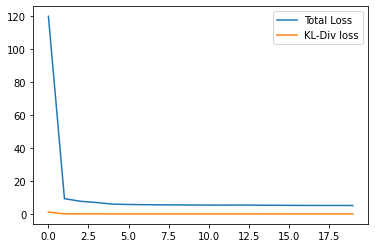

In [36]:
plt.plot(ptl,label='Total Loss')
plt.plot(pkl,label='KL-Div loss')
plt.legend()
plt.show()

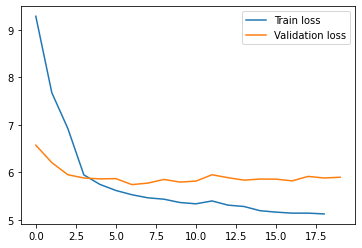

In [37]:
plt.plot(ptl[1:],label = 'Train loss')
plt.plot(pvl,label='Validation loss')
plt.legend()
plt.show()

In [38]:
def load_model(PATH,enc,dec,device):
  model = Seq2Seq(enc, dec, device, LATENT_DIM, DEC_HID_DIM).to(device)
  model.load_state_dict(torch.load(PATH,map_location=device))
  print("All keys matched successfully!")
  return model

In [39]:
PATH = "/content/var_pos_seq2seq_2_imdb.pt"
pos_model = load_model(PATH,pos_enc,pos_dec,device)

All keys matched successfully!


Negative sentiment data generation

In [40]:
NEG_REVIEW = Field(sequential=True,
                  tokenize = tokenizer,
                  use_vocab = True, 
                  init_token = '<sos>', 
                  eos_token = '<eos>', 
                  lower = True)

# ORIGINAL = Field(sequential=True,
#                 tokenize = tokenizer, 
#                 use_vocab = True,                 
#                 init_token = '<sos>', 
#                 eos_token = '<eos>', 
#                 lower = True)

fields = [('review', NEG_REVIEW)] # ('token_type', TTYPE), ('start',START), ('end',END)]

In [41]:
neg_train_data, neg_test_data = TabularDataset.splits(
                                        path = '/content/',
                                        train = 'Negative_train.csv',
                                        test = 'Negative_test.csv',
                                        format = 'csv',
                                        fields = fields,
                                        skip_header = True)
print(type(neg_train_data))
"/content/Negative_test.csv"

<class 'torchtext.legacy.data.dataset.TabularDataset'>


'/content/Negative_test.csv'

In [42]:
NEG_REVIEW.build_vocab(neg_train_data,neg_test_data, vectors = vectors) # train_data must be of type <class 'torchtext.legacy.data.dataset.TabularDataset'>
# ORIGINAL.build_vocab(train_data,test_data)  # train_data must be of type <class 'torchtext.legacy.data.dataset.TabularDataset'

In [43]:
print(len(NEG_REVIEW.vocab))
print(NEG_REVIEW.vocab.stoi['<eos>'] , NEG_REVIEW.vocab.stoi['<sos>'])
print(neg_train_data[0].__dict__.keys())
print(neg_train_data[21].__dict__.values())

27791
3 2
dict_keys(['review'])
dict_values([['it', 'had', 'all', 'the', 'clichés', 'of', 'movies', 'of', 'this', 'type', 'and', 'no', 'substance', '.', 'the', 'plot', 'went', 'nowhere', 'and', 'at', 'the', 'end', 'of', 'the', 'movie', 'i']])


In [44]:
BATCH_SIZE = 128

neg_train_iterator, neg_test_iterator = BucketIterator.splits(
                                                      (neg_train_data, neg_test_data), 
                                                      batch_size = BATCH_SIZE,
                                                      sort_key = lambda x : len(x.review),
                                                      shuffle = False,
                                                      device = device
                                                    )

In [45]:
neg_model, neg_enc, neg_dec = initialize_model(NEG_REVIEW,device)

/usr/local/lib/python3.7/dist-packages/torch/nn/modules/rnn.py:65: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  "num_layers={}".format(dropout, num_layers))


In [46]:
# def init_weights(m):
#     for name, param in m.named_parameters():
#         if 'weight' in name:
#             nn.init.normal_(param.data, mean=0, std=0.01)
#         else:
#             nn.init.constant_(param.data, 0)  #  initialise bias with 0
            
# neg_model.apply(init_weights)

In [47]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f'The model has {count_parameters(neg_model),} trainable parameters')

The model has (10601441,) trainable parameters


In [48]:
optimizer = optim.Adam(neg_model.parameters(), lr = 0.001)

TRG_PAD_IDX = NEG_REVIEW.vocab.stoi[NEG_REVIEW.pad_token]

criterion = nn.CrossEntropyLoss(ignore_index = TRG_PAD_IDX).to(device)

In [50]:
N_EPOCHS = 20
CLIP = 1

best_train_loss = float('inf')
ntl = []
nvl = []
nkl = []
sentiment = "neg"

for epoch in range(N_EPOCHS):
    
    start_time = time.time()
    
    train_loss, train_kl = train(neg_model, neg_train_iterator, optimizer, criterion, CLIP,  sentiment)
    # valid_loss = evaluate(model, test_iterator, criterion)
    
    end_time = time.time()
    
    epoch_mins, epoch_secs = epoch_time(start_time, end_time)
    
    val_loss, validation_EM_score = test(neg_model, neg_test_iterator, sentiment)

    if val_loss < best_train_loss:
        best_train_loss = val_loss
        torch.save(neg_model.state_dict(), 'var_neg_seq2seq_2_imdb.pt')
    
    print(f'Epoch: {epoch+1:02} | Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.4f} | Validation_loss : {val_loss:.4f} | Validation EM score : {validation_EM_score}')
    ntl.append(train_loss)
    nvl.append(val_loss)
    nkl.append(train_kl)

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1806: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Epoch: 01 | Time: 2m 44s
	Train Loss: 5.5035 | Validation_loss : 5.7052 | Validation EM score : 463
Epoch: 02 | Time: 2m 40s
	Train Loss: 5.4689 | Validation_loss : 5.6761 | Validation EM score : 480
Epoch: 03 | Time: 2m 40s
	Train Loss: 5.4638 | Validation_loss : 5.6446 | Validation EM score : 450
Epoch: 04 | Time: 2m 40s
	Train Loss: 5.4356 | Validation_loss : 5.7140 | Validation EM score : 452
Epoch: 05 | Time: 2m 39s
	Train Loss: 5.4288 | Validation_loss : 5.6502 | Validation EM score : 503


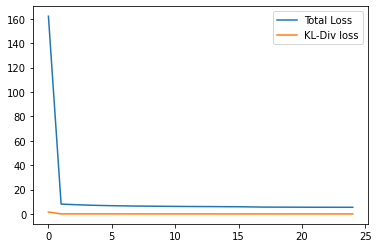

In [51]:
plt.plot(ntl,label='Total Loss')
plt.plot(nkl,label='KL-Div loss')
plt.legend()
plt.show()

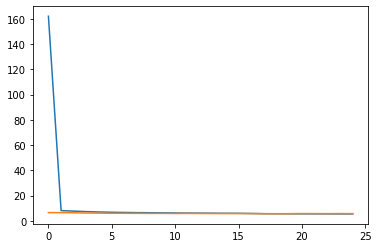

In [52]:
plt.plot(ntl)
plt.plot(nvl)
plt.show()

In [53]:
PATH = "/content/var_neg_seq2seq_2_imdb.pt"
neg_model = load_model(PATH,neg_enc,neg_dec,device)

All keys matched successfully!


In [100]:
def inference(model,sentiment):
    
  global device

  scale = -0.0009
  if sentiment == "pos":
    scale = 0.005

  N = torch.distributions.MultivariateNormal(torch.zeros(LATENT_DIM).to(device)+scale,torch.diag(torch.ones(LATENT_DIM).to(device)))
  z = N.sample().unsqueeze(0)
  # print(z.shape)

  hidden = z
  # print(hidden.shape)
  input = torch.tensor([2]).to(device)
  top1 = -1
  sentence = []

  while top1 != 3:

    output, hidden = model.decoder(input, hidden)

    top1 = output.argmax(1).item()

    if top1 != 3 and top1 != -1:
      sentence.append(top1)

    input = torch.tensor([top1]).to(device)

    if len(sentence) > 25:
      break

  return sentence

In [101]:
def generate_synthetic_review(model,REVIEW,num_of_reviews,sentiment):
  model.eval()
  new_data = []
  with torch.no_grad():
    for count in range(num_of_reviews):
      word_list = inference(model,sentiment)
      temp = []
      for word in word_list:
        temp.append(REVIEW.vocab.itos[word])
      new_data.append(' '.join(temp))

  return new_data


In [102]:
# new_pos_data = list(set(generate_synthetic_review(pos_model,POS_REVIEW,500,"pos")))
# new_pos_samples = len(new_pos_data)
new_neg_data = list(set(generate_synthetic_review(neg_model,NEG_REVIEW,500,"neg")))
new_neg_samples = len(new_neg_data)
# new_data = new_pos_data + new_neg_data
print(f"Pos samples: {new_pos_samples}, Neg samples: {new_neg_samples}")

Pos samples: 418, Neg samples: 335


In [103]:
# new_pos_data

In [104]:
new_neg_data

['',
 "to see this movie . the acting is a good . it 's a good . . the acting is",
 "i have ever seen . i was n't a huge fan of the movie . i was n't a lot of the",
 ") , i was n't a huge fan of the movie . i was n't a lot of",
 'his wife and the film is a good . the',
 'as a good . the acting is a good . the',
 '" is a good movie . the acting is a good . the acting is a good . the acting is',
 "this movie . i was n't a lot of the movie . i was n't",
 '" " the " is a good . the acting is a good . the acting is',
 "i 'm a fan of the movie . i was n't a huge fan of the movie . i was n't a lot of the",
 'ratio : " ) , " the movie is a good movie . i \'m a fan of the movie . i was n\'t a lot',
 'fi',
 '" , " the " is a good movie . the acting is a good . the acting is',
 'spoilers * * * * * * * * * * * * * * * * * * * * * * * * *',
 "i 'm a huge fan of the movie . i was n't a lot of the",
 'around the world of the film . the acting is a good .',
 'the movie is a good movie . the acting is 

In [ ]:
new_pos_data, len(new_pos_data)

(['bock teaches free at the first time and i was a bit of the first',
  'i was a fan of the movie and i was a bit of the first time i was a bit of the first',
  'andrés waissbluth worked to a big fan of the first time i was a bit of the first time i was a bit of the',
  'starring: kelsey grammar, rob schneider, alexander (emil jannings) in the manslaughter of a pushy pushy reporter.',
  'this movie is a very funny film. i can be a bit of the best movies i have ever seen. .',
  'i was a fan of the movie and i was a bit of the first time i saw this film on the "bootleg" copy of',
  "a lot of the best movies i've ever seen. i was a fan of the carpenters. face it. i don't",
  'i was a fan of the movie and i was a bit of the first time i saw this film on the n, and the other',
  'starring: pianiste" a big fan of the way.hedy lamarr was a few years of the first time i have to say that this is a very',
  'if you are not a great job of the best of the best films ever made. it is a very good jo

In [ ]:
new_neg_data

['not']

Visualise latent space of new data

In [ ]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

def get_TSNE_plot(Data_vecs, pos_num, neg_num, type_of_data="newly generated"): # numpy matrix [number of samples, ENC_HID_DIM * bidirectionality]
  tsne = TSNE(n_components = 2, random_state = 42)
  transformed_data = tsne.fit_transform(Data_vecs)

  plt.scatter(transformed_data[:pos_num,0],transformed_data[:pos_num:,1])
  plt.scatter(transformed_data[pos_num:,0],transformed_data[pos_num:,1])
  plt.title(f"TSNE plot of latent vectors (encoder compressed) of {type_of_data} data")
  plt.show()

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


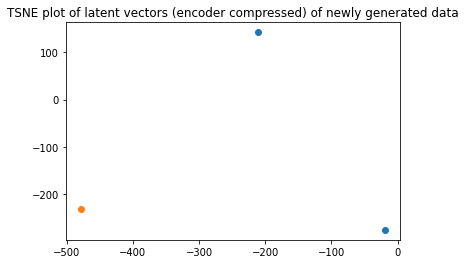

In [ ]:
def get_latent_vecs_without_train_iterator(model,ENC_HID_DIM,new_data,REVIEW,device):
  model.eval()
  hidden_vecs = np.zeros((1,ENC_HID_DIM*2))
  with torch.no_grad():
    for sentence in new_data: 
      tokens = torch.tensor([REVIEW.vocab.stoi['<sos>']] + [REVIEW.vocab.stoi[word] for word in sentence.split(' ')] + [REVIEW.vocab.stoi['<eos>']]).to(device)
      tokens = tokens.unsqueeze(-1)
      # tok2 = torch.tensor([REVIEW.vocab.stoi['<sos>']] + [REVIEW.vocab.stoi[word] for word in sent2.split(' ')] + [REVIEW.vocab.stoi['<eos>']])
      h, mu, sigma, z = model.encoder(tokens) #,tok1,tok2,a)
      hidden_vecs = np.concatenate((hidden_vecs,h.detach().cpu().numpy()),axis=0)
  return hidden_vecs[1:]

pos_hidden_vecs = get_latent_vecs_without_train_iterator(pos_model,ENC_HID_DIM,new_data[:new_pos_samples],POS_REVIEW,device)
neg_hidden_vecs = get_latent_vecs_without_train_iterator(neg_model,ENC_HID_DIM,new_data[new_pos_samples:],NEG_REVIEW,device)
newData_vecs = np.concatenate((pos_hidden_vecs,neg_hidden_vecs),axis=0)
newLabels = np.array([1]*new_pos_samples + [0]*new_neg_samples)
get_TSNE_plot(newData_vecs, new_pos_samples, new_neg_samples)
assert (new_pos_samples == pos_hidden_vecs.shape[0]) and (new_neg_samples == neg_hidden_vecs.shape[0]), "Infeasible combo!"

Visualisation of the latent space

In [ ]:
def get_latent_vecs(model,ENC_HID_DIM,train_iterator):
  model.eval()
  hidden_vecs = np.zeros((1,ENC_HID_DIM*2))
  with torch.no_grad():

    for batch in train_iterator:
          
      src = batch.review.to(device)
      trg = batch.review.to(device)
      
      h, mu, sigma, z = model.encoder(src)
      
      # h = [batch_size, encoder_hidden_dim*2] , 2=bidirectionality

      hidden_vecs = np.concatenate((hidden_vecs,h.detach().cpu().numpy()),axis=0)

    hidden_vecs = hidden_vecs[1:]
    num = hidden_vecs.shape[0]
    print(f"Number of examples : {num}")
    return hidden_vecs, num

In [ ]:
pos_model, pos_enc, pos_dec = initialize_model(POS_REVIEW,device)
neg_model, neg_enc, neg_dec = initialize_model(NEG_REVIEW,device)

/usr/local/lib/python3.7/dist-packages/torch/nn/modules/rnn.py:65: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  "num_layers={}".format(dropout, num_layers))


In [ ]:
PATH = "/content/var_pos_seq2seq_2_reduced.pt"
pos_model = load_model(PATH,pos_enc,pos_dec,device)

All keys matched successfully!


In [ ]:
PATH = "/content/var_neg_seq2seq_2_reduced.pt"
neg_model = load_model(PATH,neg_enc,neg_dec,device)

All keys matched successfully!


In [ ]:
pos_hidden_vecs, pos_num = get_latent_vecs(pos_model,ENC_HID_DIM,pos_train_iterator)

Number of examples : 5000


In [ ]:
neg_hidden_vecs, neg_num = get_latent_vecs(neg_model,ENC_HID_DIM,neg_train_iterator)

Number of examples : 5000


In [ ]:
labels = np.array([1]*pos_num + [0]*neg_num)  
Data_vecs = np.concatenate((pos_hidden_vecs,neg_hidden_vecs),axis=0)
labels = np.array(labels)

In [ ]:
get_TSNE_plot(Data_vecs, pos_num, neg_num, "original review")

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


KeyboardInterrupt: ignored

Classifier for Hidden vectors

In [ ]:
class classifier(nn.Module):

  def __init__(self,DIM):
    super(classifier,self).__init__()
    self.fc1 = nn.Linear(DIM,2)

  def forward(self,X):

      return self.fc1(X) # [batch size, enc hidden dim * bidiretionality]

bidirectionality = 1
bidirectional_encoder = True

if bidirectional_encoder:
  bidirectionality = 2

model = classifier(ENC_HID_DIM*bidirectionality).to(device)

optimizer = torch.optim.Adam(model.parameters(),lr = 0.01)
criterion = nn.CrossEntropyLoss().to(device)

In [ ]:
shuffler = np.random.permutation(len(Data_vecs))
Data_vecs = Data_vecs[shuffler]
labels = labels[shuffler]

train_sz = int(Data_vecs.shape[0]*0.85)

x_train = Data_vecs[:train_sz]
x_test = Data_vecs[train_sz:]
y_train = labels[:train_sz]
y_test = labels[train_sz:]

In [ ]:
BATCH_SIZE = 10
EPOCH = 25

best_val_loss = float('inf')
patience_factor = 5
patience = 0

for epoch in range(EPOCH):
  epoch_loss = 0
  for idx in range(0,x_train.shape[0],BATCH_SIZE):
    model.train()
    x = Data_vecs[idx:min(x_train.shape[0],idx+BATCH_SIZE)]
    y = torch.from_numpy(labels[idx:min(x_train.shape[0],idx+BATCH_SIZE)]).to(device)
    x = torch.from_numpy(x).to(device)
    y_pred = model(x.float())
    optimizer.zero_grad()
    loss = criterion(y_pred,y)
    loss.backward()
    optimizer.step()
    epoch_loss += loss.item()

  model.eval()
  with torch.no_grad():
    y_test_pred = model(torch.from_numpy(x_test).to(device).float())
    val_loss = criterion(y_test_pred,torch.from_numpy(y_test).to(device))

    if best_val_loss > val_loss.item():
      best_val_loss = val_loss.item()
    elif best_val_loss < val_loss.item():
      patience += 1

    if patience == patience_factor:
      break


  print(f"Epoch : {epoch} | Train Loss : {epoch_loss:.4f} | Val Loss : {val_loss.item():.4f}")


Epoch : 0 | Train Loss : 43.3251 | Val Loss : 0.0045
Epoch : 1 | Train Loss : 2.0989 | Val Loss : 0.0014
Epoch : 2 | Train Loss : 0.7962 | Val Loss : 0.0006
Epoch : 3 | Train Loss : 0.3976 | Val Loss : 0.0003
Epoch : 4 | Train Loss : 0.2231 | Val Loss : 0.0002
Epoch : 5 | Train Loss : 0.1330 | Val Loss : 0.0001
Epoch : 6 | Train Loss : 0.0821 | Val Loss : 0.0001
Epoch : 7 | Train Loss : 0.0517 | Val Loss : 0.0000
Epoch : 8 | Train Loss : 0.0330 | Val Loss : 0.0000
Epoch : 9 | Train Loss : 0.0213 | Val Loss : 0.0000
Epoch : 10 | Train Loss : 0.0138 | Val Loss : 0.0000
Epoch : 11 | Train Loss : 0.0090 | Val Loss : 0.0000
Epoch : 12 | Train Loss : 0.0058 | Val Loss : 0.0000
Epoch : 13 | Train Loss : 0.0038 | Val Loss : 0.0000
Epoch : 14 | Train Loss : 0.0025 | Val Loss : 0.0000
Epoch : 15 | Train Loss : 0.0016 | Val Loss : 0.0000
Epoch : 16 | Train Loss : 0.0011 | Val Loss : 0.0000
Epoch : 17 | Train Loss : 0.0007 | Val Loss : 0.0000
Epoch : 18 | Train Loss : 0.0004 | Val Loss : 0.0000
Ep

In [ ]:
model.eval()
with torch.no_grad():
  y_test_pred = model(torch.from_numpy(newData_vecs).to(device).float())
  print(f"Accuracy : {np.sum(np.argmax(y_test_pred.detach().cpu().numpy(),axis=1) == newLabels)}/{newData_vecs.shape[0]}")

Accuracy : 9/9


In [ ]:
torch.zeros(torch.tensor([1,2,3,4]).shape)

tensor([0., 0., 0., 0.])